# Simulating Particle Trajectories in a Protostellar Gas Environment

This notebook studies the evolution of test-particle trajectories embedded in a dynamically evolving gas during protostellar formation. The gas properties are not evolved self-consistently here; instead, they are taken from precomputed hydrodynamic simulations and treated as a time-dependent external medium. The Hydrodynamic snapshots were taken from [Tārā](https://plg.physlab.uni-due.de/tara-database/).

### Hydrodynamic Input
The gas background is provided as a sequence of simulation snapshots (courtesy of [Tārā](https://plg.physlab.uni-due.de/tara-database/)), containing:
- Gas density fields  
- Velocity fields  
- Temperature field

The gas density is then used to calculate the radially enclosed mass for gravity. These snapshots are sampled at discrete times during the protostellar collapse.

### Interpolation Strategy
To evaluate gas properties at arbitrary particle positions and times, we perform:
- **Temporal interpolation** between adjacent snapshots to obtain smoothly varying gas properties  
- **Spatial interpolation** of density, velocity, and temperature fields at each temporally interpolated snapshot 

This allows each particle to experience a continuous, time-dependent gas environment despite the discrete nature of the input data.

### Particle Integration
Particle trajectories are integrated forward in time under the influence of the interpolated gas fields and the gravity of the enclosed gas and the central object. At each integration step:
1. The particle position is updated.
2. Local gas properties are queried via space–time interpolation.
3. Forces and/or drag terms derived from the gas properties are applied to the particle equations of motion.

### Structure of the Notebook
- Loading and preprocessing hydrodynamic snapshots  
- Construction of spatial and temporal interpolators  
- Particle initialisation and integration setup  
- Analysis and visualisation of particle trajectories

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy.interpolate import RegularGridInterpolator, interp1d, griddata
import astropy.constants as cnst
from astropy import units
import helper
from epsilon_integrator import epsilon_implicit
from exponential_integrator import exponential_mid_point
from scipy.integrate import cumulative_simpson, simpson
import interpolator

## 1. Physical and Numerical Constants

In this section, we define the physical constants and material properties used throughout the notebook.  
All quantities are carefully expressed either in **CGS units** or in **astronomical units**, depending on
their role in the equations of motion and coupling to the hydrodynamic data. 

In [2]:
# Boltzmann constant in CGS units (erg K^-1)
k_b = cnst.k_B.cgs.value  

# Mean molecular weight of the gas (dimensionless)
# Typical value for molecular cloud gas (H2 + He)
mu = 2.3  

# Proton mass in CGS units (g)
m_p = cnst.m_p.cgs.value  

# Gravitational parameter GM_sun in CGS units (cm^3 s^-2)
# Useful for computing gravitational acceleration due to a solar-mass object
GM_constant = (cnst.G * cnst.M_sun).cgs.value  

# Solar mass in CGS units (g)
M_sun_cgs = cnst.M_sun.cgs.value  

# Intrinsic material density of the solid particle (g cm^-3)
rho_s = 1.6  

# Grain radius in CGS units (cm)
# Value taken from Tarā's hydrodynamic data
a_g = 1e-4  

# Mass of a single spherical grain (g)
m_cgs = 4 * np.pi / 3 * rho_s * a_g**3  

# Gravitational constant converted to AU^3 / (M_sun yr^2)
# This form is convenient for integrating particle orbits
G = cnst.G.to(units.AU**3 / (units.M_sun * units.yr**2)).value  

# Mass of the central protostar in solar masses
# Taken from Tarā's simulation data
int_mass_central = 0.01

### Code Unit Definitions

This cell defines the **internal code units** used to interface with the hydrodynamic snapshots and to
integrate particle trajectories consistently. We adopt astronomical units for length and time, with
derived units for density and velocity expressed in CGS for numerical convenience.

These unit conversions allow seamless translation between:
- Physical quantities stored in the simulation data
- CGS-based force and thermodynamic calculations

**Note:** The hydrodynamic data uses CGS units for gas density, particle and gas velocity. But AU for particle positions. The code here uses $\mathrm{AU}$, $\mathrm{M}_\odot$, $\mathrm{Yr}$ as units.

In [3]:
# Density unit: solar mass per cubic astronomical unit (g cm^-3)
# Used to convert simulation density fields into CGS units
density_unit = (cnst.M_sun / cnst.au**3).cgs.value  

# Time unit: one year expressed in seconds (s)
t_unit = (1. * units.year).cgs.value  

# Length unit: one astronomical unit expressed in centimeters (cm)
r_unit = cnst.au.cgs.value  

# Velocity unit derived from code length and time units (cm s^-1)
v_unit = r_unit / t_unit  

## 2. Loading and Inspecting the Hydrodynamic Dataset

In this section, we load the hydrodynamic simulation output stored in an HDF5 file and inspect its internal
structure. The dataset contains gas properties (e.g., density, velocity, temperature) saved at multiple
simulation times, organized into groups.

We first identify the earliest snapshot (by group name), and then recursively explore the datasets
contained within that snapshot to understand the available fields, their shapes, and data types.

In [4]:
wdir_database = './'
file_name = '2Ddustycollapse_dataset_m1_1mu.hdf5'
file_path = wdir_database + file_name
dataset = h5py.File(file_path, 'r')

In [5]:
with h5py.File(file_path, 'r') as f:
    first_group = sorted(list(f.keys()), key=float)[0]
    print('Tree inside group:', first_group)

    f[first_group].visit(
        lambda name: (
            print(f"{name}: shape = {f[first_group][name].shape}, dtype = {f[first_group][name].dtype}")
            if isinstance(f[first_group][name], h5py.Dataset)
            else None
        )
    )

Tree inside group: 0.0
angular_velocity: shape = (241, 30), dtype = >f4
azimuthal_velocity: shape = (241, 30), dtype = >f4
gas_density: shape = (241, 30), dtype = >f4
gas_temperature: shape = (241, 30), dtype = >f4
mean_molecular_weight: shape = (241, 30), dtype = >f4
particle_angular_position: shape = (330,), dtype = float64
particle_angular_position_cartesian: shape = (330,), dtype = float64
particle_angular_velocity: shape = (330,), dtype = float64
particle_azimuthal_velocity: shape = (330,), dtype = float64
particle_id: shape = (330,), dtype = float64
particle_radial_position: shape = (330,), dtype = float64
particle_radial_position_cartesian: shape = (330,), dtype = float64
particle_radial_velocity: shape = (330,), dtype = float64
radial_velocity: shape = (241, 30), dtype = >f4
radius: shape = (241, 30), dtype = >f4
sound_speed: shape = (241, 30), dtype = >f4
stopping_time: shape = (330,), dtype = float32
theta: shape = (241, 30), dtype = >f4
x_cartesian: shape = (241, 30), dtype 

## 3. Snapshot Ordering and Grid Construction

Here we extract the temporal ordering of the hydrodynamic snapshots and construct the spatial grid on
which the gas properties are defined.

Each HDF5 group corresponds to a simulation snapshot labeled by its time. By sorting the group names
numerically, we recover the correct temporal sequence of the simulation. A helper routine is then used
to generate the spatial grid shared by all snapshots.

In [6]:
# Snapshot group names correspond to simulation times; sort them numerically
sorted_keys = sorted(list(dataset.keys()), key=float)

# Convert snapshot times to a NumPy array (in code units)
time_array = np.array([float(t) for t in sorted_keys])

# Use a helper routine to construct the radial and angular grids
# The grid is assumed to be common across all snapshots
grid = helper.generate_grids(dataset, sorted_keys)

# Radial grid (in astronomical units, AU)
r = grid.r  

# Angular grid (polar angle, in radians)
theta = grid.theta 

linear theta grid
log radius grid


## 4. Loading Gas and Particle Data

#### Loading the Gas Properties
In this section, we load the time-dependent gas properties from the
hydrodynamic dataset. All quantities are stacked along a common time axis, producing 3D arrays with the
shape:

$$
(\, n_t,\; n_r,\; n_\theta \,)
$$

for gas fields, where:
- $n_t$ is the number of snapshots,
- $n_r$ is the number of radial grid points,
- $n_\theta$ is the number of angular grid points.

Particle quantities are stored as functions of time and correspond to Lagrangian tracer particles
embedded in the gas flow.

*Note:* The snapshots give the data in the xz plane.

In [7]:
# Gas density field (g/cm^3)
density_3D = np.stack([dataset[f"{t}/gas_density"][()] for t in sorted_keys],axis=0)

# Gas sound speed (cm/s)
cs_3D = np.stack([dataset[f"{t}/sound_speed"][()] for t in sorted_keys],axis=0)

# Gas azimuthal velocity component (cm/s)
vg_az_3D_data = np.stack([dataset[f"{t}/azimuthal_velocity"][()] for t in sorted_keys], axis=0)

# Gas radial velocity component (cm/s)
vg_r_3D_data = np.stack([dataset[f"{t}/radial_velocity"][()] for t in sorted_keys],axis=0)

# Gas angular (polar) velocity component (cm/s)
vg_ang_3D_data = np.stack([dataset[f"{t}/angular_velocity"][()] for t in sorted_keys], axis=0)

# Snapshot times extracted from group names (years)
data_time = np.array(sorted([float(t) for t in dataset.keys()]))

#### Loading the Particle Properties

In PLUTO simulations, **Lagrangian particles are not guaranteed to be stored in the same array order**
across different output snapshots. As a result, particle index `i` at time $t_1$ does *not* necessarily
refer to the same physical particle at time $t_2$. To reliably reconstruct **continuous particle trajectories**, we must explicitly track particles
using their unique **particle IDs**. This section demonstrates how particle positions and velocities
are consistently aligned across all snapshots using particle IDs as labels.

#### How This Works

1. **Particle IDs as persistent labels**  
   Each particle is assigned a unique `particle_id` by PLUTO. These IDs persist across all snapshots,
   even if the internal array ordering changes.

2. **Permutation matrix construction**  
   - For each snapshot, we compare the particle IDs to those in the first snapshot.
   - This produces a permutation matrix `perm` that maps the current ordering to the reference ordering.

3. **Reordering particle data**  
   Using `np.take_along_axis`, all particle-related arrays are reordered so that:
   - Column `i` corresponds to the **same physical particle at all times**.
   - Continuous trajectories can now be reconstructed safely.

#### Why This Is Necessary

Without ID-based alignment:
- Particle trajectories may appear discontinuous.
- Velocity–position correlations become unphysical.
- Direct comparisons with particle integrators (e.g., REBOUND) are invalid.

In [8]:
# Polar (theta) velocity component v_theta (cm/s)
v_ang_tara = np.stack([dataset[f"{t}/particle_angular_velocity"][()] for t in sorted_keys], axis=0)

# Radial velocity component v_r (cm/s)
v_r_tara = np.stack([dataset[f"{t}/particle_radial_velocity"][()] for t in sorted_keys], axis=0)

# Azimuthal velocity component v_phi (cm/s)
v_az_tara = np.stack([dataset[f"{t}/particle_azimuthal_velocity"][()] for t in sorted_keys], axis=0)

# Unique particle identifiers assigned by PLUTO
# Shape: (nt, nparticles)
idp = np.array(np.stack([dataset[f"{t}/particle_id"][()] for t in sorted_keys], axis=0), dtype=int)

# Cartesian radial coordinate (x-like, AU)
xp = np.stack([dataset[f"{t}/particle_radial_position_cartesian"][()] for t in sorted_keys], axis=0)

# Cartesian angular coordinate (z-like, AU)
zp = np.stack([dataset[f"{t}/particle_angular_position_cartesian"][()] for t in sorted_keys], axis=0)

# Spherical radial coordinate r (AU)
rp = np.stack([dataset[f"{t}/particle_radial_position"][()] for t in sorted_keys], axis=0)

# Spherical polar angle theta (radians)
thetap = np.stack([dataset[f"{t}/particle_angular_position"][()] for t in sorted_keys], axis=0)

# For each snapshot, find how particle IDs map onto the ordering of the first snapshot
# Resulting shape: (nt, nparticles)
perm = (idp[..., None] == idp[0]).argmax(axis=1)

# Align Cartesian positions
xp_aligned = np.take_along_axis(xp, perm, axis=1)
zp_aligned = np.take_along_axis(zp, perm, axis=1)

# Align velocity components
v_r_tara_aligned = np.take_along_axis(v_r_tara, perm, axis=1)
v_ang_tara_aligned = np.take_along_axis(v_ang_tara, perm, axis=1)
v_az_tara_aligned = np.take_along_axis(v_az_tara, perm, axis=1)

# Align spherical coordinates
rp_tara_aligned = np.take_along_axis(rp, perm, axis=1)
thetap_tara_aligned = np.take_along_axis(thetap, perm, axis=1)

#### The Meaning of “2.5D” in PLUTO Simulations

Although the simulation is described as **2.5-dimensional**, this does *not* mean that the system is
three-dimensional. Instead, it refers to a specific geometric and symmetry assumption:

- The computational grid is **two-dimensional**, typically in **polar coordinates** $(r, \theta)$.
- All physical quantities are assumed to be **axisymmetric**, i.e.  
  $$
  \frac{\partial}{\partial \phi} = 0
  $$
- Despite this symmetry, **all three velocity components** are evolved:
  - Radial velocity $v_r$
  - Polar (angular) velocity $v_\theta$
  - Azimuthal velocity $v_{\phi}$

This allows the simulation to capture effects such as rotation and angular momentum transport without
the full computational cost of a fully 3D simulation. The “half” dimension refers precisely to this
additional velocity component in an otherwise 2D geometry.


## 5. Selecting and Initializing a Test Particle

In this section, we select a single Lagrangian particle from the PLUTO simulation output and use its
initial coordinates to initialise a corresponding particle in a REBOUND or custom N-body
integration. The selected particle serves as a controlled test case for studying particle–gas coupling and orbital
evolution in a prescribed, time-dependent gas background.

#### Notes on the Coordinate Transformation

- The original particle data are given in **axisymmetric spherical coordinates** following the PLUTO
  convention.
- Even though the simulation is 2.5D, the presence of an azimuthal velocity component allows the
  reconstruction of full 3D Cartesian velocities.
- This transformation ensures consistency between the hydrodynamic simulation output and the N-body integrator, which requires positions and velocities in Cartesian coordinates.

This initialisation step anchors the particle to the same physical state as the corresponding
PLUTO tracer at the start of the simulation.

In [9]:
# Index of the particle chosen for the experiment
test_par = 90  

# Initial polar (angular) position of the particle (radians)
test_par_theta = thetap_tara_aligned[0, test_par]

# Initial radial position of the particle (AU)
test_par_r = rp_tara_aligned[0, test_par]

# Initial polar (theta) velocity component (cm/s)
test_par_v_ang = v_ang_tara_aligned[0, test_par] 

# Initial radial velocity component (cm/s)
test_par_v_r = v_r_tara_aligned[0, test_par] 

# Initial azimuthal velocity component (cm/s)
test_par_v_az = v_az_tara_aligned[0, test_par]

# Transform axisymmetric spherical coordinates and velocities into 3D Cartesian form
# This step is required to interface with the N-Body Code, which operates in Cartesian coordinates
positions, velocities = helper.axisymmetric_spherical_to_cartesian_2p5D(
    test_par_r,
    test_par_theta,
    test_par_v_r,
    test_par_v_ang,
    test_par_v_az
)

# Cartesian position components (AU)
test_x, test_y, test_z = positions[0], positions[1], positions[2]

# Cartesian velocity components (cm/s)
test_vx, test_vy, test_vz = velocities[0], velocities[1], velocities[2]

## 6. Computing the Enclosed Gas Mass at the Particle Location

This function computes the **total mass enclosed within the spherical radius of a particle** at a given
time, based on the interpolated gas density field from [Tārā](https://plg.physlab.uni-due.de/tara-database/). The enclosed mass includes:
- The contribution from the gas distribution (obtained by integrating the density field), and
- A central point-mass contribution representing the protostar.

This quantity is used to evaluate the gravitational acceleration acting on the particle. The enclosed mass inside a spherical radius $R$ is defined as
$$ M(<R) = M_{\star} + \int_{0}^{R} \int_{0}^{\pi}
\int_{0}^{2\pi}
\rho(r,\theta)\,
r^{2}\sin\theta
\; d\phi \, d\theta \, dr
$$

The axisymmetric system gives, and all quantities are independent of the azimuthal angle $\phi$, giving $\int_{0}^{2\pi} d\phi = 2\pi$. The final integral becomes:
$$
M(<R)=
M_{\star}
+
2\pi
\int_{0}^{R}
\int_{0}^{\pi}
\rho(r,\theta)\,
r^{2}\sin\theta
\; d\theta \, dr
$$

In [10]:
def mass_enclosed(data):
    """
    Compute the total mass enclosed within the particle's radius.

    Parameters
    ----------
    data : array-like
        Particle state vector of the form:
        [x, y, z, vx, vy, vz, t],
        where positions are in AU, velocities in cm/s,
        and t is the current simulation time (years).

    Returns
    -------
    M_R : float
        Enclosed mass within radius R, in units of solar masses.
    """
    # Map particle position to the first quadrant to enforce axisymmetry
    # (required for interpolation on a 2.5D PLUTO grid)
    x, y, z = helper.position_mapper(data[0], data[1], data[2])

    # Spherical radius of the particle (AU)
    R = np.sqrt(x**2 + y**2 + z**2)

    # Current simulation time
    t = data[-1]
    # Interpolate the 3D gas density array to the current time t
    # Resulting shape: (nr, ntheta)
    rho_g_t = interpolator.interpolate(density_3D, time_array, t)

    Int = (r_unit**3* simpson(r[:, None]**2 * np.sin(theta)[None, :] * rho_g_t * 4 * np.pi, x=theta)/ M_sun_cgs)

    # Radial cumulative integral to obtain enclosed mass M(<r)
    # The central protostellar mass is included as the inner boundary value
    m_cumulative = cumulative_simpson(Int, x=r, initial=int_mass_central)
    # Construct an interpolator for M(<r)
    # Values outside the grid are clamped to the boundary values
    mass_at_R = interp1d(r, m_cumulative, bounds_error=False, fill_value=(m_cumulative[0], m_cumulative[-1]))

    # Enclosed mass at the particle radius
    M_R = mass_at_R(R)

    return M_R

## 7. Computing Local Gas Properties and Stopping Time

This function evaluates **local gas properties at the particle position** and computes the
**stopping time** relevant for dust–gas coupling. All quantities are interpolated
consistently in both space and time from the PLUTO hydrodynamic snapshots. The returned values are used to construct drag forces acting on particles during the
integration.

### Physical Interpretation

- Gas properties are interpolated **in time** (between PLUTO snapshots) and **in space**
  (from the axisymmetric $(r,\theta)$ grid to the particle’s Cartesian position).
- The stopping time is computed assuming the **Epstein drag regime**, appropriate for small grains
  in protostellar environments.
- The Keplerian frequency is evaluated using the enclosed central mass and sets the local dynamical
  timescale of the disk/envelope.
- The interpolation scheme sets the gas properties to zero once the particle crosses the mid-plane.

### Important Notes

- The returned velocity components follow the **PLUTO convention**:
  - `vg_r` → radial velocity $v_r$
  - `vg_ang` → polar velocity $v_\theta$
  - `vg_az` → azimuthal velocity $v_\phi$
- Care must be taken when combining these with Cartesian particle velocities in the numerical integration.

This function provides the local gas state required to compute drag forces acting on dust particles.

In [11]:
def compute_values(data):
    """
    Compute local gas velocities and dust stopping time at the particle position.

    Parameters
    ----------
    data : array-like
        Particle state vector containing:
        [x, y, z, vx, vy, vz, t], where positions are in AU,
        velocities in cm s^-1, and t is the simulation time (years).

    Returns
    -------
    vg_az : float
        Local gas azimuthal velocity v_phi (cm s^-1).
    vg_r : float
        Local gas radial velocity v_r (cm s^-1).
    vg_ang : float
        Local gas polar (theta) velocity v_theta (cm s^-1).
    t_stop : float
        Aerodynamic stopping time of the particle (s).
    """
    t = data[-1]

    # Map particle position to the first quadrant (axisymmetric assumption)
    x, y, z = helper.position_mapper(data[0], data[1], data[2])  # AU

    # Spherical radius of the particle (AU)
    R = np.sqrt(x**2 + y**2 + z**2)

    # Interpolate sound speed field in time
    cs_t = interpolator.interpolate(cs_3D, time_array, t)

    # Interpolate sound speed at particle position (cm s^-1)
    c_s = interpolator.interpolate_cartesian(x, z, r, theta, cs_t)

    # Mean thermal speed of gas molecules
    v_th = np.sqrt(8 / np.pi) * c_s  # cm s^-1

    # Keplerian angular frequency at particle radius (s^-1)
    Omega_k = np.sqrt(GM_constant / (R * r_unit)**3)

    # Gas pressure scale height (cm)
    h_g = c_s / Omega_k

    # Azimuthal gas velocity v_phi (cm s^-1)
    vg_az_t = interpolator.interpolate(vg_az_3D_data, time_array, t)
    vg_az = interpolator.interpolate_cartesian(x, z, r, theta, vg_az_t)

    # Radial gas velocity v_r (cm s^-1)
    vg_r_t = interpolator.interpolate(vg_r_3D_data, time_array, t)
    vg_r = interpolator.interpolate_cartesian(x, z, r, theta, vg_r_t)

    # Polar (theta) gas velocity v_theta (cm s^-1)
    vg_ang_t = interpolator.interpolate(vg_ang_3D_data, time_array, t)
    vg_ang = interpolator.interpolate_cartesian(x, z, r, theta, vg_ang_t)
    
    # Interpolate gas density field in time
    rho_g_t = interpolator.interpolate(density_3D, time_array, t)

    # Interpolate gas density at particle position (g cm^-3)
    rho_g = interpolator.interpolate_cartesian(x, z, r, theta, rho_g_t)

    # Prevent numerical issues at very low densities
    rho_g = np.maximum(rho_g, 1e-20)  # g cm^-3
    v_th = np.maximum(v_th, 1e-15)    # cm s^-1

    # Epstein-regime stopping time for a spherical grain
    t_stop = (rho_s * a_g) / (rho_g * v_th)  # s

    return vg_az, vg_r, vg_ang, t_stop

## 8. Simulation Setup: Time Parameters

In this section, we define the **temporal parameters** for the particle integration.  
These parameters determine the duration of the simulation and the resolution of the time-stepping.

We choose a small time step to resolve the fast dynamics of particles in the dense, rotating
protostellar environment.

### Notes on Time Resolution

- The chosen time step `dt` should be **small enough to resolve**:
  - Rapid orbital motion in the inner protostellar envelope
  - Gas drag effects (set by the stopping time)
  
- The total integration time `t_max` allows the particle to traverse a significant portion
  of the collapsing envelope.

- Careful consideration of **time-step vs stopping time** is crucial for stable integration of
  tightly coupled dust–gas systems.

In [12]:
# Time step for particle integration (years)
dt = 0.1  

# Total simulation time (years)
t_max = 15000

# Number of integration steps
n_steps = int(t_max / dt)

## 9. Particle Integration: Implicit and Exponential Mid-Point Methods

In this section, we integrate the motion of the test particle in the protostellar gas environment
using two different numerical schemes:

1. **Epsilon Implicit Integration**  
   - An implicit scheme designed to handle stiff equations arising from strong gas drag
     (small stopping times).  
   - Provides stability even when the particle is tightly coupled to the gas.  

2. **Exponential Mid-Point Integration**  
   - A semi-implicit, second-order accurate method.  
   - Efficient for systems with moderate drag and allows accurate long-term integration.

Both methods use the **local gas properties** (from `compute_values`) and the **enclosed mass**
(`mass_enclosed`) to compute forces acting on the particle. Outputs are in Cartesian coordinates
for direct analysis. To read more about these integrators, check out these notebooks [available here](https://github.com/rajatsaxena314/Semi-Implicit-and-Exponential-Mid-Point-Integrators).

In [13]:
#Epsilon Implicit Integration
x, y, z, v_x, v_y, v_z, time = epsilon_implicit(test_x, test_y, test_z, test_vx/v_unit, test_vy/v_unit, test_vz/v_unit, n_steps, dt, 
                     G, compute_values, mass_enclosed, helper, t_unit=t_unit, v_unit=v_unit, r_unit=r_unit)

100%|██████████████████████████████████| 149999/149999 [03:36<00:00, 694.14it/s]


## 10. Full-Time Particle Trajectory from Tārā

Here we extract the **entire trajectory of the selected particle** from the PLUTO simulation
for comparison with the integration. Unlike the single-time initialization used for
integration, this uses **all snapshots** to reconstruct the particle’s motion over time. The data are converted from **axisymmetric spherical coordinates** (2.5D PLUTO) to **3D Cartesian**
coordinates, allowing direct comparison with particle integration results.

### Notes

- This data represents the **ground truth** trajectory of the particle from the hydrodynamic simulation.
- Conversion to Cartesian coordinates allows for:
  - Direct comparison with REBOUND-integrated trajectories.
  - Visualization in 3D plots.
- Using the full-time trajectory can help **validate the accuracy** of the implicit or mid-point
  integration schemes under varying drag conditions.

In [14]:
# Angular (theta) positions for all snapshots
test_par_theta_all = thetap_tara_aligned[:, test_par]

# Radial positions for all snapshots (AU)
test_par_r_all = rp_tara_aligned[:, test_par]

# Angular (theta) velocities for all snapshots (cm/s)
test_par_v_ang_all = v_ang_tara_aligned[:, test_par]

# Radial velocities for all snapshots (cm/s)
test_par_v_r_all = v_r_tara_aligned[:, test_par]

# Azimuthal velocities for all snapshots (cm/s)
test_par_v_az_all = v_az_tara_aligned[:, test_par]

positions_all, velocities_all = helper.axisymmetric_spherical_to_cartesian_2p5D(
    test_par_r_all,
    test_par_theta_all,
    test_par_v_r_all,
    test_par_v_ang_all,
    test_par_v_az_all
)

# Cartesian positions (AU)
test_x_all = positions_all[:, 0]
test_y_all = positions_all[:, 1]
test_z_all = positions_all[:, 2]

# Cartesian velocities (cm/s)
test_vx_all = velocities_all[:, 0]
test_vy_all = velocities_all[:, 1]
test_vz_all = velocities_all[:, 2]

## 11. Comparison of Particle Trajectories: Custom N-body vs Tārā

This section visualizes the **Cartesian positions** of the particle over time, comparing:

- `"mine"` → particle integrated using the REBOUND scheme (epsilon implicit or exponential mid-point)
- `"test"` → particle trajectory directly from the PLUTO simulation (full snapshot data)

Plots are organized as:

- **Rows**: spatial coordinates $x, y, z$
- **Columns**: N-Body integration (`mine`) vs PLUTO data (`test`)

This comparison helps assess how well the integration scheme reproduces the reference particle trajectory.


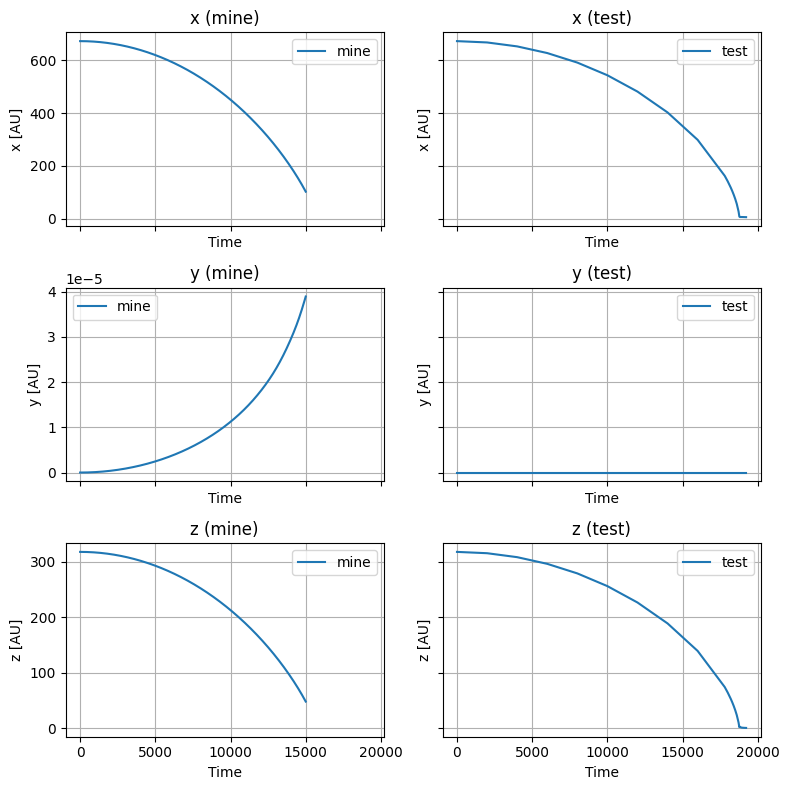

In [15]:
fig, axes = plt.subplots(3, 2, figsize=(8, 8), sharex=True, sharey='row') 

# --- Row 1: vx ---
axes[0, 0].plot(time, x, label='mine')
axes[0, 0].set_title('x (mine)')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('x [AU]')
axes[0, 0].legend()
axes[0, 0].grid(True)

axes[0, 1].plot(data_time, test_x_all, label='test')
axes[0, 1].set_title('x (test)')
axes[0, 1].set_xlabel('Time')
axes[0, 1].set_ylabel('x [AU]')
axes[0, 1].legend()
axes[0, 1].grid(True)

# --- Row 2: vy ---
axes[1, 0].plot(time, y, label='mine')
axes[1, 0].set_title('y (mine)')
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('y [AU]')
axes[1, 0].legend()
axes[1, 0].grid(True)

axes[1, 1].plot(data_time, test_y_all, label='test')
axes[1, 1].set_title('y (test)')
axes[1, 1].set_xlabel('Time')
axes[1, 1].set_ylabel('y [AU]')
axes[1, 1].legend()
axes[1, 1].grid(True)

# --- Row 3: vz ---
axes[2, 0].plot(time, z, label='mine')
axes[2, 0].set_title('z (mine)')
axes[2, 0].set_xlabel('Time')
axes[2, 0].set_ylabel('z [AU]')
axes[2, 0].legend()
axes[2, 0].grid(True)

axes[2, 1].plot(data_time, test_z_all, label='test')
axes[2, 1].set_title('z (test)')
axes[2, 1].set_xlabel('Time')
axes[2, 1].set_ylabel('z [AU]')
axes[2, 1].legend()
axes[2, 1].grid(True)

plt.tight_layout()
plt.savefig("positions_model_vs_tara.png")
plt.show()

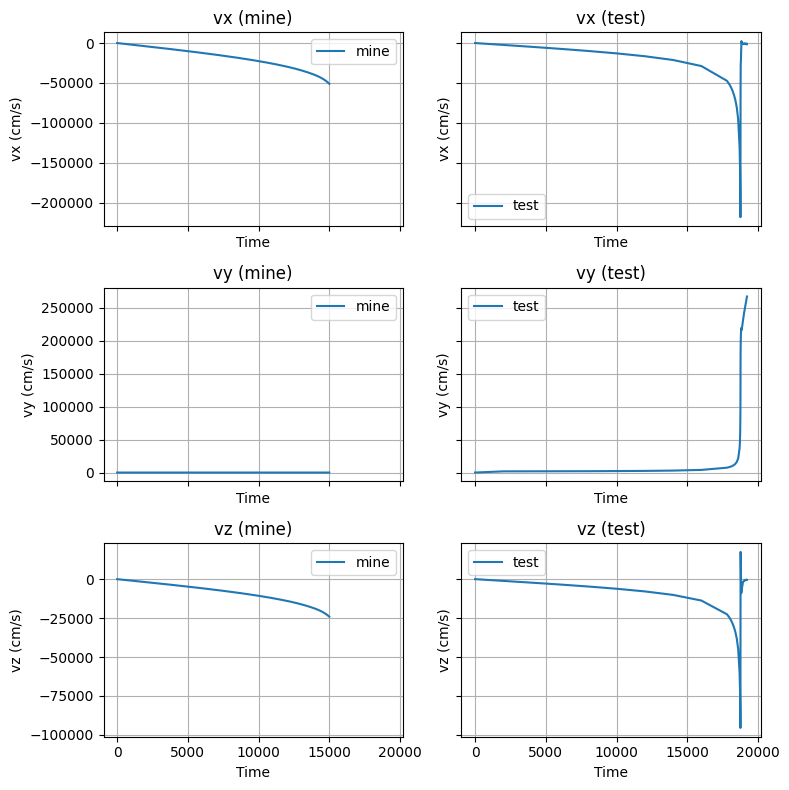

In [16]:
fig, axes = plt.subplots(3, 2, figsize=(8, 8), sharex=True, sharey='row') 

# --- Row 1: vx ---
axes[0, 0].plot(time, v_x*v_unit, label='mine')
axes[0, 0].set_title('vx (mine)')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('vx (cm/s)')
axes[0, 0].legend()
axes[0, 0].grid(True)

axes[0, 1].plot(data_time, test_vx_all, label='test')
axes[0, 1].set_title('vx (test)')
axes[0, 1].set_xlabel('Time')
axes[0, 1].set_ylabel('vx (cm/s)')
axes[0, 1].legend()
axes[0, 1].grid(True)

# --- Row 2: vy ---
axes[1, 0].plot(time, v_y*v_unit, label='mine')
axes[1, 0].set_title('vy (mine)')
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('vy (cm/s)')
axes[1, 0].legend()
axes[1, 0].grid(True)

axes[1, 1].plot(data_time, test_vy_all, label='test')
axes[1, 1].set_title('vy (test)')
axes[1, 1].set_xlabel('Time')
axes[1, 1].set_ylabel('vy (cm/s)')
axes[1, 1].legend()
axes[1, 1].grid(True)

# --- Row 3: vz ---
axes[2, 0].plot(time, v_z*v_unit, label='mine')
axes[2, 0].set_title('vz (mine)')
axes[2, 0].set_xlabel('Time')
axes[2, 0].set_ylabel('vz (cm/s)')
axes[2, 0].legend()
axes[2, 0].grid(True)

axes[2, 1].plot(data_time, test_vz_all, label='test')
axes[2, 1].set_title('vz (test)')
axes[2, 1].set_xlabel('Time')
axes[2, 1].set_ylabel('vz (cm/s)')
axes[2, 1].legend()
axes[2, 1].grid(True)

plt.tight_layout()
plt.savefig("velocity_model_vs_tara.png")
plt.show()